In [1]:
from models import Unet_Model, CNN_Model
import time
import numpy as np
import tensorflow as tf

from datetime import datetime
import keras
from keras import layers
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop

2024-10-24 20:27:57.114638: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 20:27:57.128149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 20:27:57.142012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 20:27:57.146196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 20:27:57.159040: I tensorflow/core/platform/cpu_feature_guar

# Dataset

In [2]:
def import_data(path):
    x_train = np.load(path + "/x_train.npy")
    x_val = np.load(path + "/x_val.npy")
    x_test = np.load(path + "/x_test.npy")
    y_train = np.load(path + "/y_train.npy")
    y_val = np.load(path + "/y_val.npy")
    y_test = np.load(path + "/y_test.npy")
    z_train = np.load(path + "/z_train.npy")
    z_val = np.load(path + "/z_val.npy")
    z_test = np.load(path + "/z_test.npy")

    return x_train, x_val, x_test, y_train, y_val, y_test, z_train, z_val, z_test

In [3]:
# import dataset
x_train, x_val, x_test, y_train, y_val, y_test, z_train, z_val, z_test = import_data("data128")

# Train Unet

In [4]:
# Model Parameter
input_shape = (128,128,1)
init_filter = 16
drop_rate = 0.1
up_sampling = False
regularization = None
batch_norm = True

# Training Parameter
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = "binary_crossentropy"
metrics = ["accuracy"]
epochs = 50

I0000 00:00:1729776487.332995   34517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729776487.388968   34517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729776487.389012   34517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729776487.390846   34517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729776487.390895   34517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
unet = Unet_Model(
    input_shape=input_shape, 
    init_filter=init_filter, 
    drop_rate=drop_rate, 
    up_sampling=up_sampling, 
    regularization=regularization, 
    batch_norm=batch_norm
)

In [6]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[

 Total params: 2,212,801 (8.44 MB)

 Trainable params: 2,209,857 (8.43 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [7]:
unet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
with open("training_output_unet.txt", "a") as f:
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"Test run at {current_time}\n", file=f)

    start_time = time.time()
    results = unet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)
    training_time = time.time() - start_time

    print("Loss", results.history["loss"][0])
    print("Validation loss", results.history["val_loss"][0])

    print(f"Loss: {results.history['loss'][0]}", file=f)
    print(f"Validation loss: {results.history['val_loss'][0]}", file=f)
    print(f"Training time: {training_time}", file=f)

    unet.save("models/UNet_model.h5")

f.close()

Epoch 1/50


I0000 00:00:1729776499.355799   34714 service.cc:146] XLA service 0x7facd8004640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729776499.355830   34714 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-24 20:28:19.543662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-24 20:28:20.411437: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729776518.817117   34714 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 887ms/step - accuracy: 0.8083 - loss: 0.5303 - val_accuracy: 0.4860 - val_loss: 7.8135
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9226 - loss: 0.3372 - val_accuracy: 0.1114 - val_loss: 12.6986
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9359 - loss: 0.2602 - val_accuracy: 0.1866 - val_loss: 9.6374
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9429 - loss: 0.2231 - val_accuracy: 0.1629 - val_loss: 11.4523
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9509 - loss: 0.1934 - val_accuracy: 0.2400 - val_loss: 8.2293
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9496 - loss: 0.1825 - val_accuracy: 0.5037 - val_loss: 3.8765
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9550 - loss: 0.1650 - val_accuracy: 0.8186 - val_loss: 0.6507
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9550 - loss: 0.1587 - val_accuracy: 0.6640 - val_loss

Loss 0.463354229927063
Validation loss 7.813487529754639


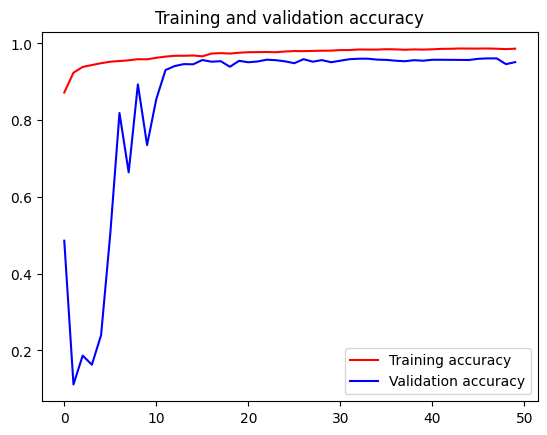

<Figure size 640x480 with 0 Axes>

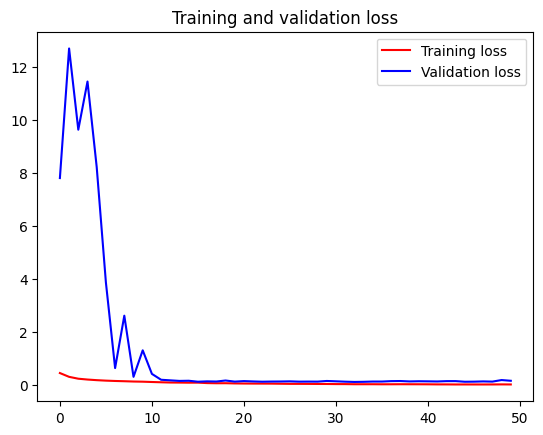

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

# Train CNN

In [10]:
# Model Parameter
input_shape = (128,128,1)
num_layer = 3
num_unit = 64
drop_rate = 0.05

# Training Parameter
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs = 20

In [11]:
cnn = CNN_Model(
    input_shape=input_shape, 
    num_layer=num_layer, 
    num_unit=num_unit, 
    drop_rate=drop_rate
)

In [12]:
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ concatenate_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 20,296,643 (77.43 MB)

 Trainable params: 1,974,659 (7.53 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [13]:
cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
def encode(x):
    x[x=="normal"] = 0
    x[x=="benign"] = 1
    x[x=="malignant"] = 2
    x = x.astype(int)

    return x

In [15]:
def onehot_encode(x):
    x = encode(x)
    x_onehot = np.zeros((x.size, x.max()+1))
    x_onehot[np.arange(x.size),x] = 1

    return x_onehot

In [16]:
z_train_onehot = onehot_encode(z_train)
z_val_onehot = onehot_encode(z_val)
z_test_onehot = onehot_encode(z_test)

In [17]:
with open("training_output_cnn.txt", "a") as f:
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"Test run at {current_time}\n", file=f)

    masks_train_pred = unet.predict(x_train)
    masks_val_pred = unet.predict(x_val)

    start_time = time.time()
    results = cnn.fit([x_train, masks_train_pred], z_train_onehot, validation_data=([x_val, masks_val_pred], z_val_onehot), epochs=epochs)
    training_time = time.time() - start_time

    start_time = time.time()
    predictions = cnn.predict([x_test, unet.predict(x_test)])
    inference_time = time.time() - start_time

    _, accuracy_val = cnn.evaluate([x_val, unet.predict(x_val)], z_val_onehot, verbose=0)
    _, accuracy_test = cnn.evaluate([x_test, unet.predict(x_test)], z_test_onehot, verbose=0)
    print("Validation accuracy:", accuracy_val)
    print("Test accuracy:", accuracy_test)
    print("Training time", training_time)
    print("Inference time", inference_time)

    print(f"Validation accuracy: {accuracy_val}", file=f)
    print(f"Test accuracy: {accuracy_test}", file=f)
    print(f"Training time: {training_time}", file=f)
    print(f"Inference time: {inference_time}", file=f)

    cnn.save("models/CNN_model.h5")

f.close()

20/20 ━━━━━━━━━━━━━━━━━━━━ -1s 73ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5747 - loss: 1.0123 - val_accuracy: 0.7692 - val_loss: 0.7925
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8611 - loss: 0.3543 - val_accuracy: 0.7949 - val_loss: 0.7560
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9345 - loss: 0.1661 - val_accuracy: 0.7949 - val_loss: 0.7435
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9478 - loss: 0.1564 - val_accuracy: 0.7564 - val_loss: 0.9679
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9629 - loss: 0.1157 - val_accuracy: 0.7949 - val_loss: 0.9408
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9842 - loss: 0.0507 - val_accuracy: 0.7821 - val_loss: 0.9747
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9934 - loss: 0.0271 - val_accuracy: 0.7949 - val_loss: 1.0961
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━

Validation accuracy: 0.7948718070983887
Test accuracy: 0.8227847814559937
Training time 84.68268895149231
Inference time 14.265043497085571


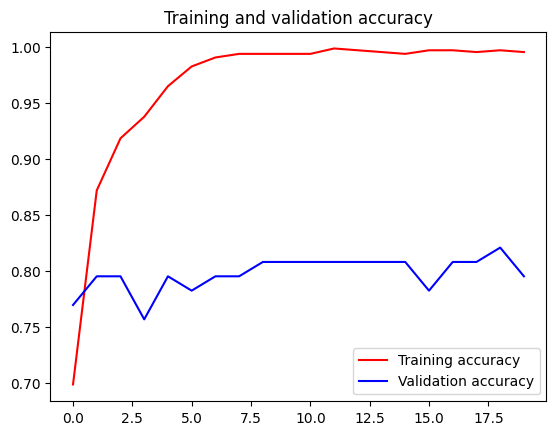

<Figure size 640x480 with 0 Axes>

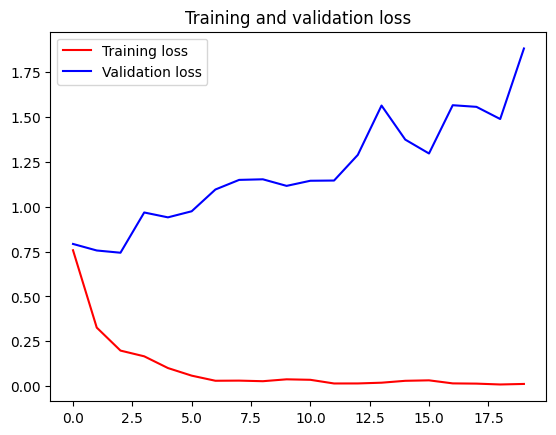

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()